# Are you on PC or MAC? pc = 0, mac = 1

In [1]:
computer = 0
#! source activate tensorflow

# 1) Libraries

In [70]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas_datareader.data as web
import datetime
import pandas as pd
import os
import csv
import glob as glob
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from time import time

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )

# 2) Import

In [71]:
# Comprehensive way to set the path to Data directory

ROOTPATH = os.getcwd()

path_data = os.path.join(ROOTPATH, 'Data')
path_train = os.path.join(path_data, 'train_set')
path_test = os.path.join(path_data, 'test_set')
path_validation = os.path.join(path_data, 'validation_set')

## Import the list of tickers

In [72]:
if computer == 0:
    with open('IBB_holdings.csv', 'r') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1

if computer == 1:
    with open('IBB_holdings.csv', 'r', encoding ='mac_roman') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1            

list_tickers.sort()
list_tickers.pop()
list_tickers.remove("BLKFDS")
list_tickers.remove("USD")
list_tickers.remove("SNDX")

## Importing functions

In [73]:
def get_data(path):
    list_dataframes=[]
    allFiles = glob.glob(path + "/csv" + "*.csv")
    i = 0
    list_tickers = []
    
    if computer == 0:
        for file_ in allFiles:
            with open(file_, 'r') as csvfile:
                list_dataframes.append(pd.read_csv(csvfile, index_col=None, header=0))
                list_tickers.append(file_.split('_')[4])
                i+=1

    if computer == 1:
        for file_ in allFiles:
            with open(file_, 'r', encoding ='mac_roman') as csvfile:
                list_dataframes.append(pd.read_csv(csvfile, index_col=None, header=0))
                list_tickers.append(file_.split('_')[4])
                i += 1
    
    num_files = i
    
    return num_files, list_dataframes, list_tickers


In [74]:
def normalize_data(num_files, list_dataframes, list_tickers):
    
    maxi = 0
    length = 0
    compt = 0
    j = 0
    
    for df in list_dataframes:
        if len(df) > maxi:
            maxi = len(df['Adj Close'])
    
    data = np.array([np.zeros(maxi)]*(num_files))
    data_normalized = np.array([np.zeros(maxi)]*(num_files))
    
    i = 0
    
    for df in list_dataframes:
        arr = np.array(df['Adj Close'])
        if len(arr) == maxi and not df['Adj Close'].isnull().values.any(): 
            data[j] = arr
            minimum = np.min(arr)
            maximum = np.max(arr)
            arr = (arr - minimum) / (maximum - minimum)
            data_normalized[j] = arr
            j += 1
        else:
            list_tickers.pop(i)
            compt += 1
            i-=1
        i += 1
    
    return data_normalized[:-compt], data[:-compt], list_tickers

## Create training, validation and testing set

In [75]:
train_setDf = get_data(path_train)

validation_setDf = get_data(path_validation)

test_setDf = get_data(path_test)

In [76]:
train_setData_n, train_setData, list_tickers_train = normalize_data(train_setDf[0], train_setDf[1], train_setDf[2])

validation_setData_n, validation_setData, list_tickers_val = normalize_data(validation_setDf[0], validation_setDf[1], validation_setDf[2])

test_setData_n, test_setData, list_tickers_test = normalize_data(test_setDf[0], test_setDf[1], test_setDf[2])

print("train_setData is of length : ",len(train_setData))
print("test_setData is of length : ",len(test_setData))
print("validation_setData is of length : ",len(validation_setData))

train_setData is of length :  114
test_setData is of length :  28
validation_setData is of length :  27


# 3) Functions

## Initializing functions

In [77]:
def weight_variable(num_input, num_output):
    weight_init = tf.random_normal_initializer(stddev=1.0/np.sqrt(num_input))
    weight_shape = [num_input, num_output]
    W = tf.get_variable('W', weight_shape, initializer = weight_init)
    return(W)

def bias_variable(num_output):
    bias_init = tf.constant_initializer(value = 0)
    bias_shape = [num_output]
    b = tf.get_variable('b', bias_shape, initializer = bias_init)
    return(b)

## Fetch data functions

In [78]:
def find_ticker_batch(batch, data_norm, list_tickers):
    true = batch
    index = -1
    i = 0
    while index < 0:
        if data_norm[i][100] - true[100] == 0:
            index = i
        i += 1
    ticker = list_tickers[index]
    return(ticker, index)

## Tensorboard functions

In [79]:
def variable_summary_light(var):
    with tf.variable_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)

In [80]:
def variable_summary(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [81]:
def create_summaries(loss, x, latent, output):
    writer = tf.summary.FileWriter("./logs")
    tf.summary.scalar("Loss", loss)
    layer_grid_summary("Input", x, [28, 28])
    layer_grid_summary("Encoder", latent, [2, 1])
    layer_grid_summary("Output", output, [28, 28])
    return writer, tf.summary.merge_all()

## Training functions

In [82]:
def next_batch(batch_size, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.array(data_shuffle), np.array(labels_shuffle)

In [83]:
def layer_batch_normalization(x, n_out, phase_train):

    beta_init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_init)

    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
        
    mean, var = tf.cond(phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))

    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    
    return tf.reshape(normed, [-1, n_out])

## Building functions

In [180]:
def layer(input_tensor, num_input, num_output, phase_train, layer_name, bool_drop):
    with tf.variable_scope(layer_name):
        with tf.variable_scope('weights'):
            W = weight_variable(num_input, num_output)
            variable_summary_light(W)
    
        with tf.variable_scope('biases'):
            b = bias_variable(num_output)
            variable_summary_light(W)
            
        
        dropped = dropout(input_tensor, keep_prob)
        if bool_drop:
            logits = tf.matmul(dropped, W) + b
        else:
            logits = tf.matmul(input_layer, W) + b
    return tf.nn.tanh(layer_batch_normalization(logits, num_output, phase_train)), W

In [181]:
def encoder(input_tensor, num_input, num_output, phase_train):
    with tf.variable_scope("encode"):
        
        with tf.variable_scope('output'):
            output, W_e = layer(input_tensor, num_input, num_output, phase_train, "encoder",True)
            
    return output, W_e

def decoder(input_tensor, num_input, num_output, phase_train):
    with tf.variable_scope("decode"):
        
        with tf.variable_scope('output'):
            output, W_d = layer(input_tensor, num_input, num_output, phase_train, "decoder",True)
            
    return output, W_d


In [182]:
def dropout(encoder_op, keep_prob):
    with tf.variable_scope("dropped"):
        dropped = tf.nn.dropout(encoder_op, keep_prob)
    return dropped

In [183]:
def mse(output, x):
    with tf.variable_scope('mse'):
        mse = tf.squared_difference(output, x)
    return mse

In [184]:
def regularizer(W_e, W_d):
    with tf.variable_scope("regularizer"):
        regularizer = tf.nn.l2_loss(W_e) + tf.nn.l2_loss(W_d)
    return regularizer

In [185]:
def loss(mse, regularizer, lambd, num_input, batch_size):
    with tf.variable_scope("loss"):
        loss = tf.reduce_sum(mse + lambd * regularizer)/(num_input * batch_size * 2)
    return loss

In [186]:
def training(loss, learning_rate):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    return train_op

In [187]:
def evaluate(output, x):
    with tf.variable_scope('validation'):
        
        l2_norm = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x, name="val_diff")), 1))
        
        val_loss = tf.reduce_mean(l2_norm)
        
        val_summary_op = tf.summary.scalar("val_cost", val_loss)
        
        return val_loss, val_summary_op

# 4) Training

## Parameters

In [188]:
# Training Parameters
learning_rate = 0.001
num_steps = 600
batch_size = 10
lambd = 0.1
val_dropout = 1

display_step = 100

# Network Parameters 

num_input = 503 # 503 days considered
num_hidden_1 = 250 # 1st layer num features
num_output = num_input


date = str(int(time()))

logs_path = '/tmp/tensorflow_logs/autoencoder1/'+date+'/'

## Run the training

In [189]:
with tf.Graph().as_default():
    with tf.variable_scope("autoencoder_model"):
        
        # Placeholders
        x = tf.placeholder("float", [None, num_input])
        phase_train = tf.placeholder(tf.bool)
        keep_prob = tf.placeholder(tf.float32) #gateway for dropout
        
        # Extract the latent information (logits from the bottleneck layer)
        code, W_e = encoder(x,num_input, num_hidden_1, phase_train)
        
        # Extract the outputs of the autoencoder
        output, W_d = decoder(code, num_hidden_1, num_output, phase_train)
        
        cost = loss(mse(output,x), regularizer(W_e, W_d), lambd, num_input, batch_size)
        
        train_op = training(cost, learning_rate)
        
        eval_op, val_summary_op = evaluate(output, x)
        
        # Merge all the summaries - variables, training - into a single operation
        summary_op = tf.summary.merge_all()
        
        # Save the trained model for later use (testing)
        saver = tf.train.Saver()        
        
        # Create the session that will be runned for training
        sess = tf.Session()
        
        # Initialize a summary for our variables during the training
        summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
        
        # Time to launch the session
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        
        start_time = time()
        
        for i in range(1, num_steps+1):
            
            # Prepare Data
            total_batch = int(len(train_setData_n)/batch_size)

            for j in range(total_batch):
                mini_batch_x, _ = next_batch(batch_size, train_setData_n, train_setData_n)

                _, l, summary = sess.run([train_op, cost, summary_op], 
                            feed_dict={x: mini_batch_x, phase_train: True, keep_prob: val_dropout})

            # Write on the log file the datas for TensorBoard / First: summary, Second: overall step
            summary_writer.add_summary(summary, i)
                
            if i % display_step == 0 or i == 1:
                
                print('Step %i: Minibatch Loss: %f' % (i, l))
                curr_time = time()
                elapsed_time = curr_time-start_time
                print('Estimated remaining time = ', elapsed_time / i * (num_steps-i),'s\n')
                  
        batch_x, _ = next_batch(batch_size,test_setData_n,test_setData_n)
        l , p = sess.run([cost, output] , feed_dict={x: batch_x, phase_train: False, keep_prob: 1})
        print('Minibatch Loss: ', l) 
       

Step 1: Minibatch Loss: 14.355663
Estimated remaining time =  93.09019231796265 s

Step 100: Minibatch Loss: 0.013465
Estimated remaining time =  35.19970417022705 s

Step 200: Minibatch Loss: 0.011711
Estimated remaining time =  28.433582782745358 s

Step 300: Minibatch Loss: 0.011430
Estimated remaining time =  21.551292419433594 s

Step 400: Minibatch Loss: 0.016521
Estimated remaining time =  14.497541785240173 s

Step 500: Minibatch Loss: 0.015020
Estimated remaining time =  7.214379739761352 s

Step 600: Minibatch Loss: 0.010234
Estimated remaining time =  0.0 s

Minibatch Loss:  0.015368346


# 8) Exporting

In [190]:
print("Run the command line:\n" \
          "--> tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/"+date+"/" \
          "\nThen open http://0.0.0.0:6006/ into your web browser\n\n")
print("Or Run the command line:\n" \
          "--> python -m tensorboard.main --logdir=C:\\tmp\\tensorflow_logs\\autoencoder1\\"+date+"\\" \
          "\nThen open http://desktop-p6qj80l:6006/ into your web browser, or anything the command tells you to type\n\n")

Run the command line:
--> tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/1519335327/
Then open http://0.0.0.0:6006/ into your web browser


Or Run the command line:
--> python -m tensorboard.main --logdir=C:\tmp\tensorflow_logs\autoencoder1\1519335327\
Then open http://desktop-p6qj80l:6006/ into your web browser, or anything the command tells you to type




In [191]:
#! tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/1519250108/

# 9) Plotting

In [192]:
#V2
def denormalize(p,batch, dataset_norm, dataset, list_tickers):
    batch_size = len(batch)
    unnormalized_p = {}
    for j in range(batch_size):
        (ticker, index) = find_ticker_batch(batch[j], dataset_norm, list_tickers)

        minimum = np.min(dataset[index])
        maximum = np.max(dataset[index])
        pred = p[j] * (maximum - minimum) + minimum
        unnormalized_p[index] = (ticker, pred)
        
    return unnormalized_p
    
unnormalized_p = denormalize(p, batch_x, test_setData_n, test_setData, list_tickers_test)

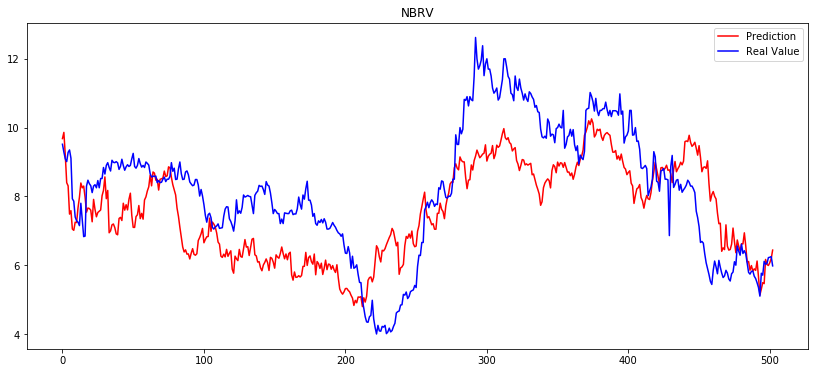

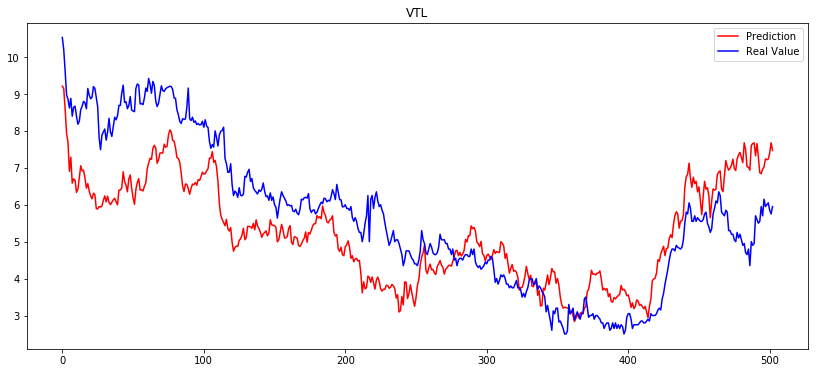

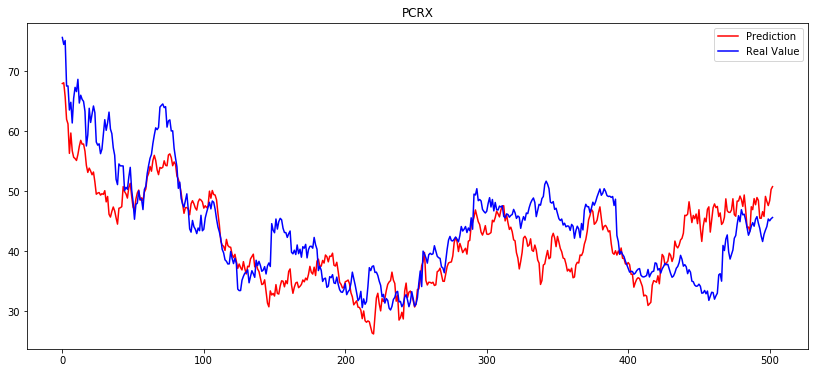

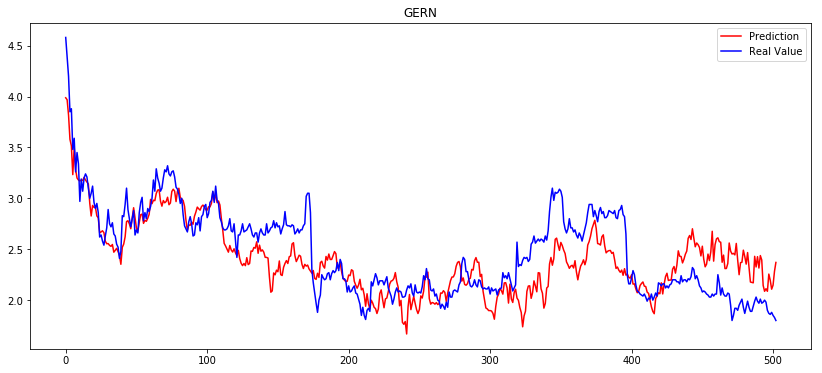

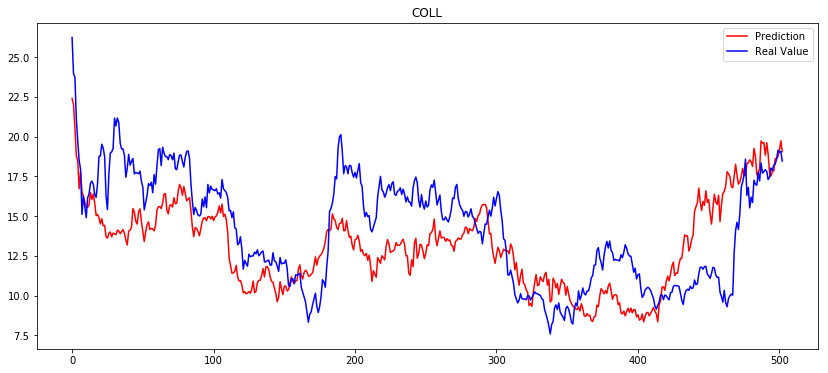

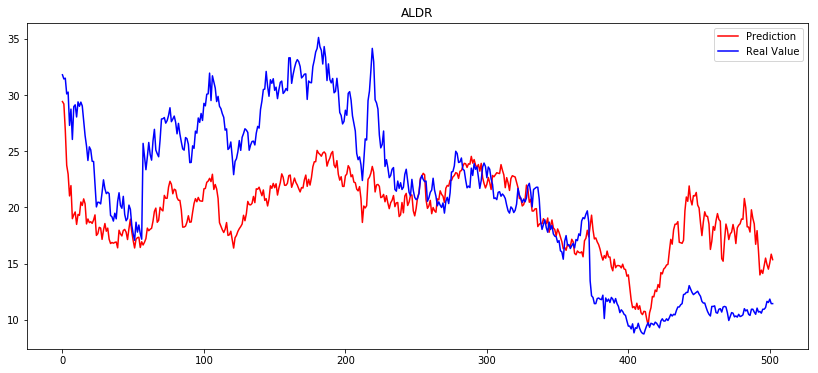

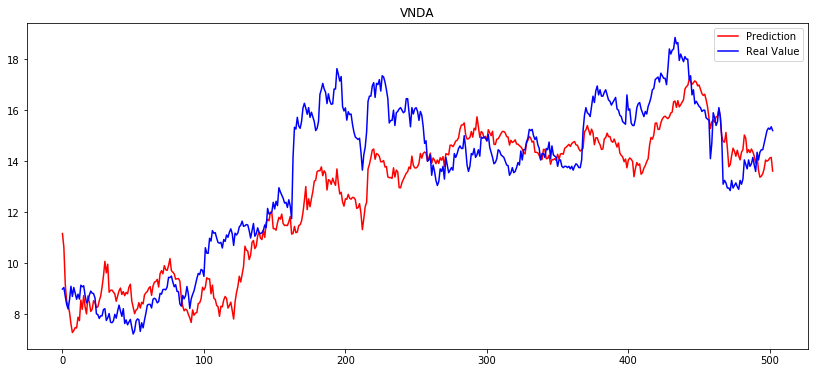

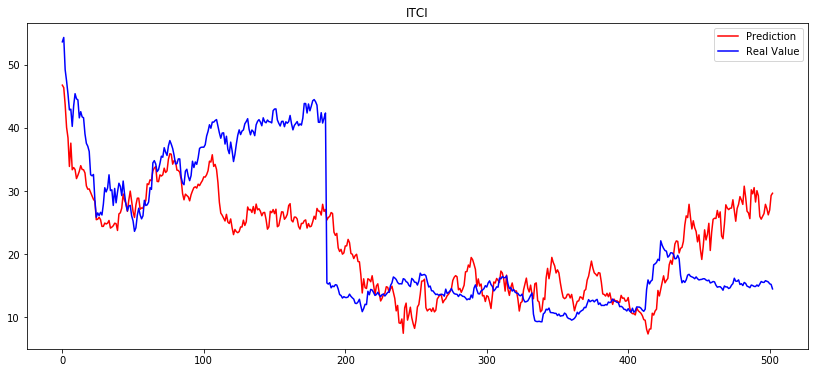

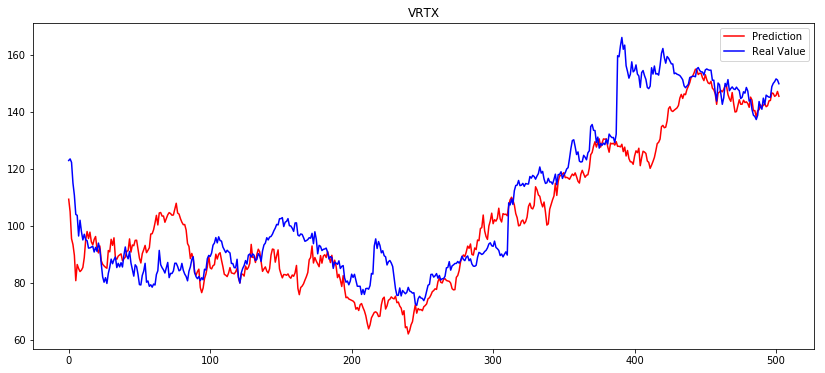

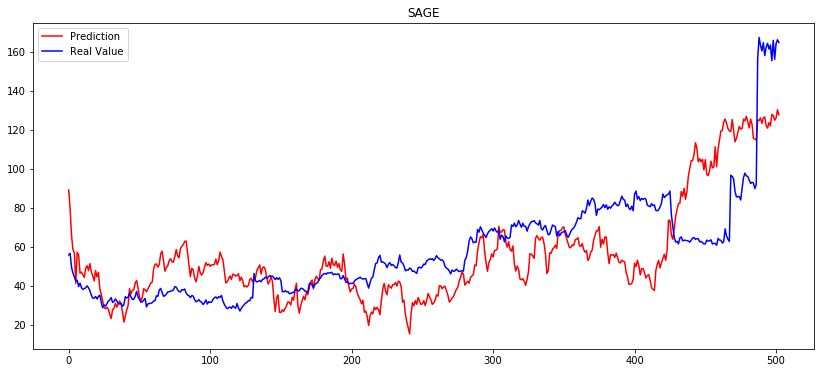

In [193]:
for j in unnormalized_p.keys():
    plt.figure()
    plt.plot(unnormalized_p[j][1] ,'r',label="Prediction")
    plt.hold
    plt.plot(test_setData[j] ,'b', label='Real Value')
    plt.title(unnormalized_p[j][0])
    plt.legend()
    plt.show;

# Re checking

In [194]:
diff = abs(p - batch_x)

In [195]:
for i in diff:
    print(i)

[1.92110612e-02 6.61573705e-02 1.25706820e-02 7.11552051e-02
 1.13047891e-01 2.16325508e-01 1.77056146e-01 1.01995805e-01
 9.82950185e-02 1.74257092e-02 5.85758589e-03 4.86322061e-02
 9.56578435e-02 6.83675711e-02 1.07702323e-01 1.70541637e-01
 1.30774271e-01 8.80467518e-02 9.37551285e-02 8.38018516e-02
 8.24522078e-02 9.84082191e-02 4.49407323e-02 8.33248128e-02
 9.78152892e-02 1.07727224e-01 7.90732643e-02 1.06210451e-01
 5.81385600e-02 7.72206046e-02 9.81011026e-03 1.12219782e-01
 9.36371714e-02 2.20170245e-01 2.01820365e-01 2.17942801e-01
 2.07931172e-01 2.19008896e-01 2.43612196e-01 2.42678939e-01
 1.65637199e-01 1.71717384e-01 2.06657489e-01 1.27507927e-01
 1.34588286e-01 1.27877296e-01 1.52274745e-01 1.10986957e-01
 9.36656016e-02 1.90268633e-01 2.49463916e-01 2.05588498e-01
 1.63304747e-01 1.66222514e-01 1.58452128e-01 1.85269992e-01
 1.55883514e-01 1.81236775e-01 1.09557764e-01 1.17640424e-01
 9.31290862e-02 7.33509753e-02 4.90841069e-03 2.93667728e-02
 1.39588968e-02 1.125964

In [196]:
print('average error in our case = ',np.mean(diff))

average error in our case =  0.12370796660341518


In [197]:
random = np.random.uniform(0,1,(10,503))

In [198]:
diff_random = abs(batch_x - random)
print('average error in a random case = ',np.mean(diff_random))

average error in a random case =  0.3282137749972016


# Finding the commonals

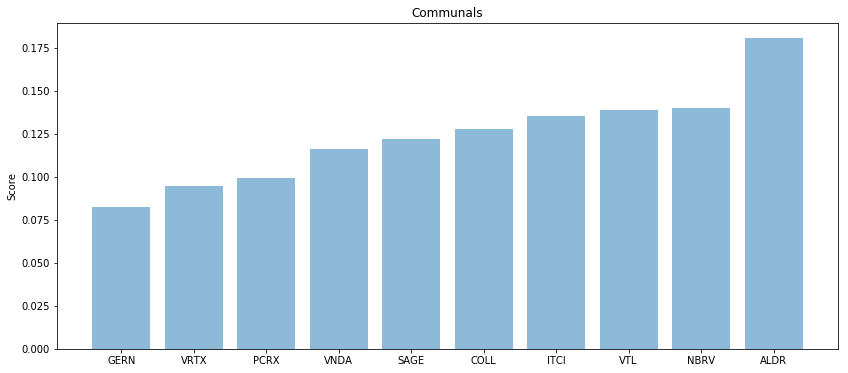

In [199]:



sorted_by_value = []

for i in range(len(p)):
    sorted_by_value.append((np.mean(diff[i]),i))
    
objects =  []
performance = sorted(sorted_by_value)

for i in performance:
    ticker, index = find_ticker_batch(batch_x[i[1]], test_setData_n, list_tickers_test)
    objects.append(ticker)

    
y_pos = np.arange(len(objects))
plotable_performance = [i[0] for i in performance]


plt.bar(y_pos, plotable_performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Score')
plt.title('Communals')
 
plt.show();


